# Assignment 5


## Part B: Classification

- Ruchita Bhadre ()
- Trupal Patel (1008326152)


### Problem Statement


Imports


In [1]:
import warnings
from dataclasses import dataclass
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from imblearn.over_sampling import ADASYN
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from pandas import DataFrame
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


Boilerplate


In [2]:
warnings.filterwarnings("ignore")
RANDOM_STATE = 1628


Loading the data


In [3]:
DATA_FOLDER = "data/"
DATA_FOLDER_URL = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
)
DATA_FILE_RED = "winequality-red.csv"
DATA_FILE_WHITE = "winequality-white.csv"

df_red = pd.read_csv(DATA_FOLDER_URL + DATA_FILE_RED, sep=";")
df_red["type"] = "red"

df_white = pd.read_csv(DATA_FOLDER_URL + DATA_FILE_WHITE, sep=";")
df_white["type"] = "white"

df = pd.concat([df_red, df_white], ignore_index=True)


In [4]:
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [5]:
df.columns


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')

In [6]:
df.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
df["type"].value_counts()


white    4898
red      1599
Name: type, dtype: int64

### About the Data

- The inputs include physicochemical tests and the output is based on sensory data (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality between 0 (very bad) and 10 (very excellent).
- Number of Instances: red wine - 1599; white wine - 4898.
- Number of Features: 12 (type of wine is included).
  - fixed acidity
  - volatile acidity
  - citric acid
  - residual sugar
  - chlorides
  - free sulfur dioxide
  - total sulfur dioxide
  - density
  - pH
- Labels: 3 to 9


### Exploratory Data Analysis


#### Box plots


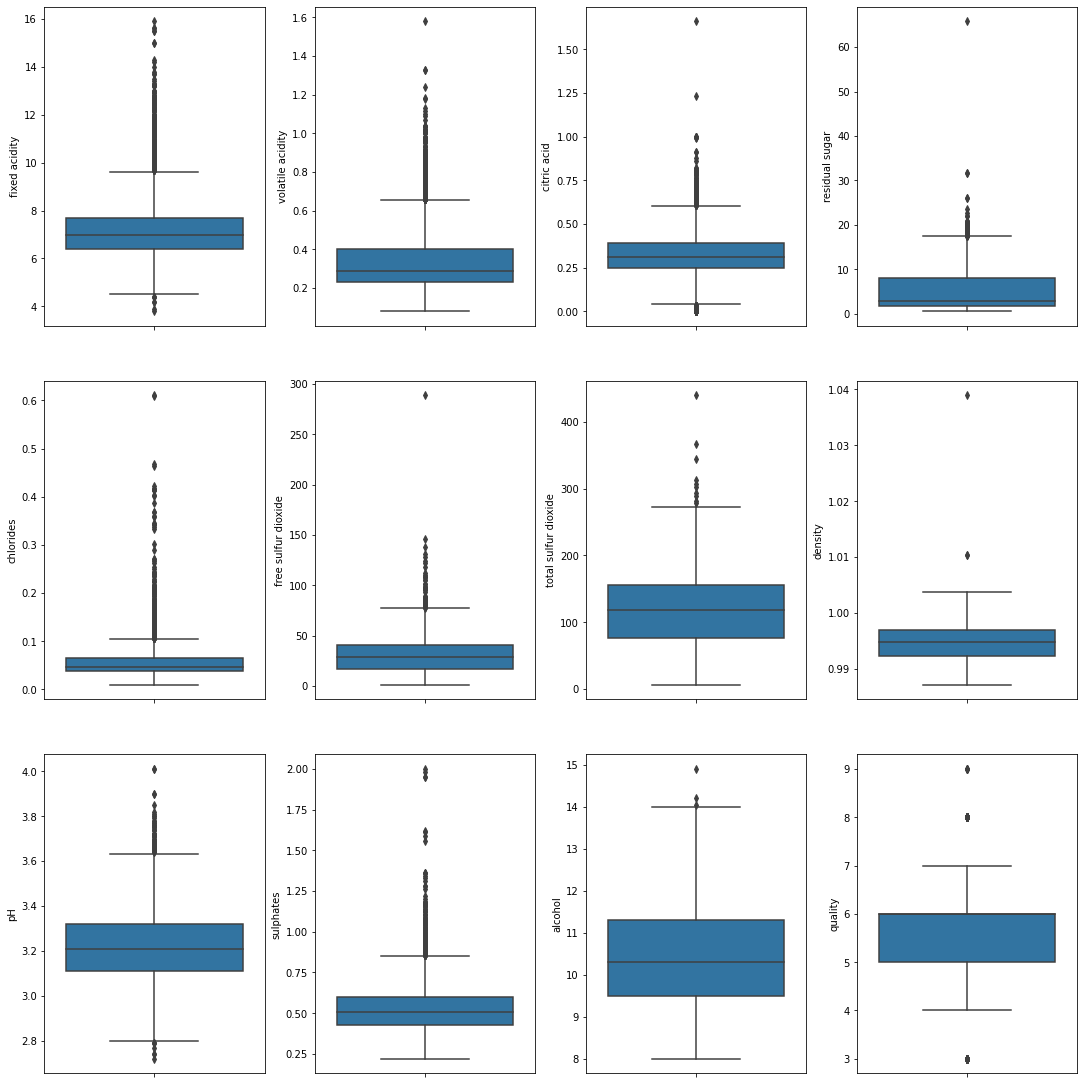

In [8]:
def create_box_plots(df: DataFrame, columns: list[str] | None = None):
    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(15, 15))
    index = 0
    ax = ax.flatten()

    if columns is None:
        columns = df.columns.tolist()

    for column in columns:
        if column != "type":
            sns.boxplot(y=column, data=df, ax=ax[index])
            index += 1
    plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)


create_box_plots(df)


Almost all the features have outliers on the upper end of the distribution with some on the lower end.


#### Correlation matrix


<AxesSubplot:>

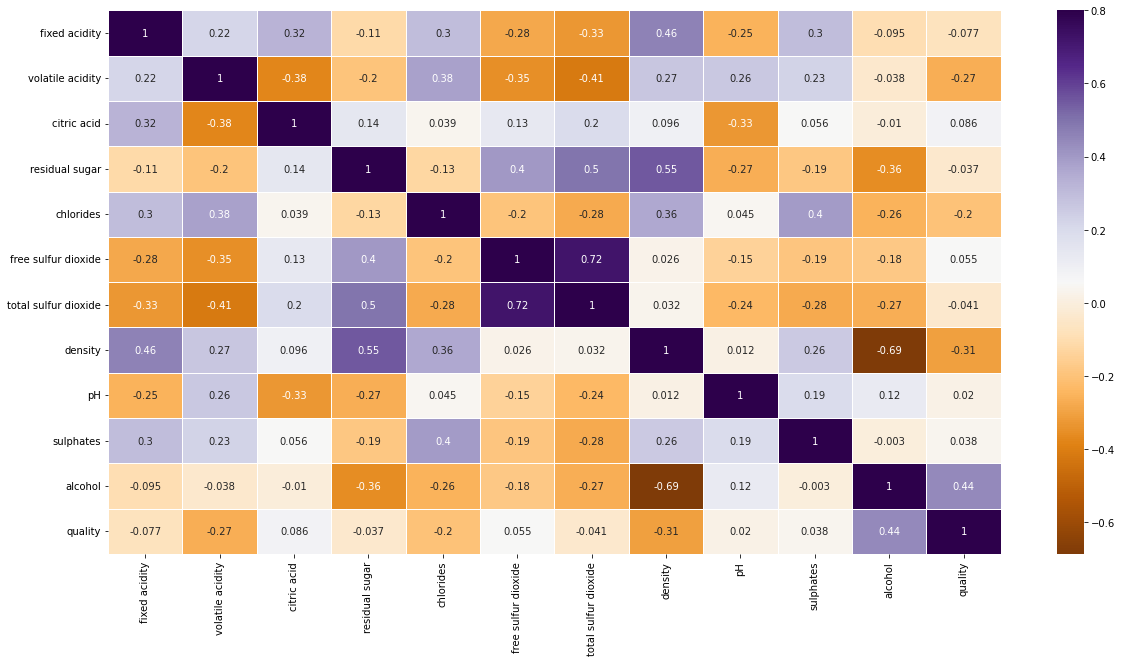

In [9]:
corr = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap="PuOr", vmax=0.8, linewidths=0.5)


From the correlation matrix, we can see that the features are not that correlated. We see mixed relationships between the features but all around zero.

alcohol and density have high negative correlation, while total sulfur dioxide and free sulfur dioxide have high positive correlation.


#### Distribution plots


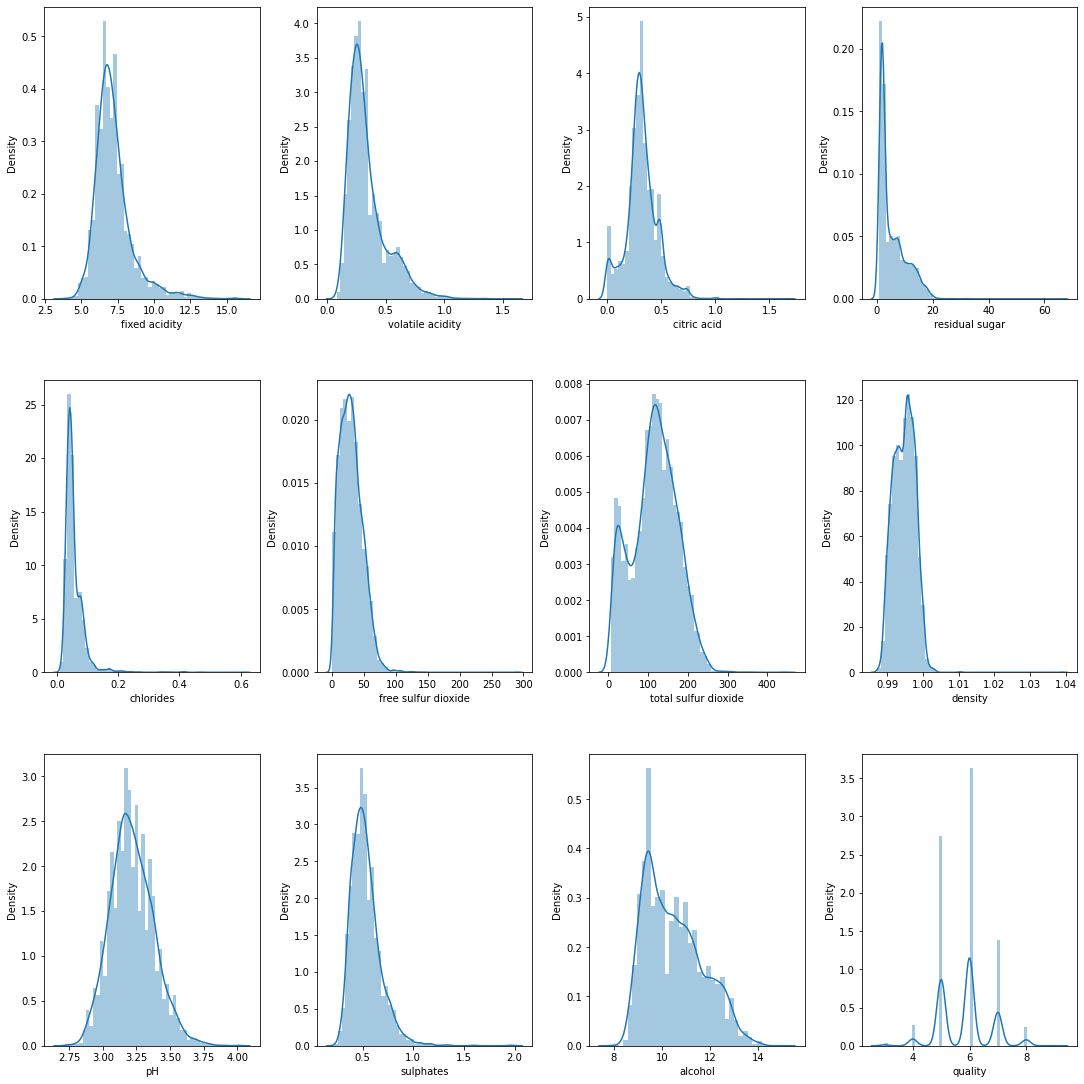

In [10]:
def create_dist_plots(df: DataFrame, columns: list[str] | None = None):
    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(15, 15))
    index = 0
    ax = ax.flatten()

    if columns is None:
        columns = df.columns.tolist()

    for column, value in df.items():
        if column != "type" and column in columns:
            sns.distplot(value, ax=ax[index])
            index += 1
            plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)


create_dist_plots(df)


From the graphs, we can see that most variables are right skewed, most noticeably density, citric_acid, chlorides and free sulfur dioxide.

pH has a normal distribution and so does others if outliers are not counted. Total sulfur dioxide and citric acid have a bimodal distribution.


#### Red vs White


<AxesSubplot:xlabel='type', ylabel='count'>

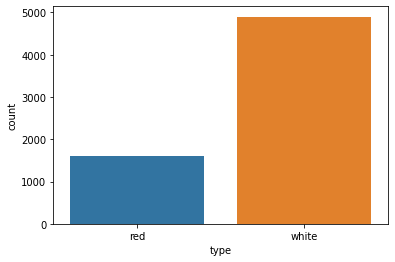

In [11]:
sns.countplot(x="type", data=df)


White wine samples are more in numbers than red wine.


#### Class Distribution


<AxesSubplot:xlabel='quality', ylabel='count'>

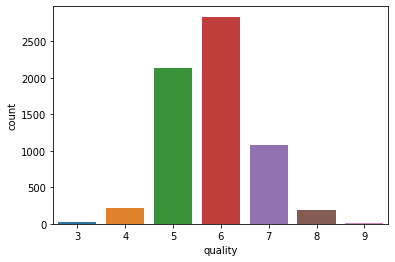

In [12]:
sns.countplot(x="quality", data=df)


We can see that the data is imbalanced, as the number of samples for qualities 6 and 5 are much more than the others.


### Preprocessing


In [13]:
df.isnull().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

there are no `NA` values in the data so no need to impute.


In [14]:
X = df.drop(columns=["quality"])
y = df["quality"]


#### One hot Encoding


In [15]:
categorical_columns = ["type"]

for column in categorical_columns:
    dummies = pd.get_dummies(X[column], prefix=column)
    X = pd.concat([X, dummies], axis=1)
    X = X.drop(column, axis=1)


Categorical variables are encoded using one hot encoding to get a numerical representation of them.


In [16]:
X


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0,1


#### Balancing the data


In [17]:
y.value_counts().sort_index()


3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

Since there is a class imbalance, we need to balance the data so our model is not biased towards one class.


In [18]:
# balance the df using ADASYN
X_resampled, y_resampled = ADASYN(n_neighbors=4, n_jobs=-1).fit_resample(X, y)


In [19]:
y_resampled.value_counts().sort_index()


3    2844
4    2772
5    2437
6    2836
7    2871
8    2800
9    2835
Name: quality, dtype: int64

### Splitting the data into train and test sets


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_STATE
)


### Standardization


In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Training


Helper Class to store the training results


In [22]:
@dataclass
class Result:
    model: Pipeline
    model_name: str
    accuracy: float
    CV_score: float
    time_taken: float
    rmse: float
    f1_score: float
    confusion_matrix: DataFrame

    def __str__(self) -> str:
        return """{model_name}
=======================
Accuracy: {accuracy:.2f}\t\tCV Score: {CV_score:.2f}
RMSE: {rmse:.2f}\t\tF1 Score: {f1_score:.2f}
Time Taken: {time_taken:.2f} (s)\n""".format(
            **self.__dict__
        )


list of models to be trained

these models are good for classification problems, hence we have chosen the following models


In [23]:
models_list = [
    LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE),
    KNeighborsClassifier(n_jobs=-1),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    LinearSVC(random_state=RANDOM_STATE),
    RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_jobs=-1, random_state=RANDOM_STATE),
]


helper function to train the models


In [24]:
def classify(
    model: Pipeline,
    X_train: DataFrame,
    y_train: DataFrame,
    X_test: DataFrame,
    y_test: DataFrame,
):
    """
    Splits the data into train and test sets and fits the model to the data.

    Arguments
    ---------
        model : A sklearn model
        X : features
        y : labels

    Returns
    -------
        result : a `Result` object with the model's performance metrics
    """

    # train the model
    start = perf_counter()
    model.fit(X_train, y_train)
    end = perf_counter()

    # predictions
    y_pred = model.predict(X_test)

    return Result(
        model_name=model.__class__.__name__,
        accuracy=model.score(X_test, y_test),
        CV_score=np.mean(cross_val_score(model, X, y, cv=5)),
        time_taken=end - start,
        confusion_matrix=pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            index=sorted(y_test.unique()),
            columns=sorted(y_test.unique()),
        ),
        rmse=mean_squared_error(y_test, y_pred, squared=False),
        f1_score=f1_score(y_test, y_pred, average="weighted"),
        model=model,
    )


Training the models


In [25]:
results = [classify(model, X_train, y_train, X_test, y_test) for model in models_list]


### Results


In [26]:
pd.DataFrame([result.__dict__ for result in results]).drop(
    ["confusion_matrix", "model"], axis=1
)


,model_name,accuracy,CV_score,time_taken,rmse,f1_score
0,LogisticRegression,0.529518,0.440682,2.797350,1.355101,0.520676
1,KNeighborsClassifier,0.793503,0.385880,0.060228,0.686293,0.779851
2,DecisionTreeClassifier,0.803300,0.390949,0.253634,0.685729,0.801002
3,LinearSVC,0.513792,0.381258,7.697841,1.447990,0.489704
4,RandomForestClassifier,0.884506,0.477471,0.708001,0.422980,0.881530
5,ExtraTreesClassifier,0.896623,0.477628,0.369060,0.386015,0.893985


### Hyperparameter Tuning


Extra trees classifier is the best model for this dataset which gives high accuracy, F1 score, and cv score for a low training time.


In [27]:
# grid search for hyperparameter tuning for ExtraTreesClassifier
param_grid = {
    "max_features": ["log2", "sqrt"],
    "min_samples_split": [1, 2, 4],
    "min_samples_leaf": [1, 2, 4],
}

# create a cross validation object
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
# create a grid search object
grid_search = GridSearchCV(
    ExtraTreesClassifier(random_state=RANDOM_STATE), param_grid, cv=cv, n_jobs=-1
)
# fit the grid search object to the data
grid_search.fit(X_train, y_train)
# view the best parameters
best_params = grid_search.best_params_
print(best_params)

# view the best model
best_model = grid_search.best_estimator_

# view the performance of the best model
grid_search.best_estimator_.score(X_test, y_test)


{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


0.8966228409383862

- `min_samples_split` : The minimum number of samples required to split an internal node
- `min_samples_leaf` : The minimum number of samples required to be at a leaf node.
- `max_features` : The number of features to consider when looking for the best split


In [28]:
# train the model with best parameters
best_result = classify(
    ExtraTreesClassifier(n_jobs=-1, **best_params), X_train, y_train, X_test, y_test
)
print(best_result)


ExtraTreesClassifier
Accuracy: 0.90		CV Score: 0.47
RMSE: 0.40		F1 Score: 0.89
Time Taken: 0.48 (s)



confusion matrix for the model


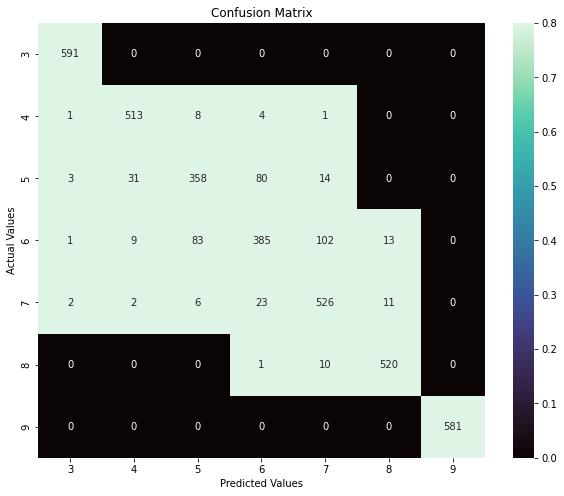

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(best_result.confusion_matrix, annot=True, cmap="mako", vmax=0.8, fmt="g")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()


There wasn't much improvement in the accuracy of the model after tuning the hyperparameters. The model is still good for classification. Tuning other hyperparameters like `n_estimators` might improve the model.
